# Fishing for User Data in Large-Batch Federated Learning via Gradient Magnification


This notebook shows an example for a **arbitrary batch image gradient inversion** as described in "Fishing for User Data in Large-Batch Federated Learning via Gradient Magnification". The setting is a pretrained ResNet-18 and the federated learning algorithm is **fedSGD** in a **cross-silo** setting.

Paper URL: https://arxiv.org/abs/2202.00580

This variant fishes for user data of a single target user by refining an estimate of the user's data distribution over a series of queries. The attacker constructs a binary tree over successive queries until a single data point from the user side is successfully isolated. On average, this should take $\log(n)$ queries for users with $n$ data points from the class that is currently attacked.

#### Abstract
Federated learning (FL) has rapidly risen in popularity due to its promise of privacy and efficiency. Previous works have exposed privacy vulnerabilities in the FL pipeline by recovering user data from gradient updates. However, existing attacks fail to address realistic settings because they either 1) require a `toy' settings with very small batch sizes, or 2) require unrealistic and conspicuous architecture modifications. We introduce a new strategy that dramatically elevates existing attacks to operate on batches of arbitrarily large size, and without architectural modifications. Our model-agnostic strategy only requires modifications to the model parameters sent to the user, which is a realistic threat model in many scenarios. We demonstrate the strategy in challenging large-scale settings, obtaining high-fidelity data extraction in both cross-device and cross-silo federated learning.

### Startup

In [1]:
try:
    import breaching
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import breaching
    
import torch
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

### Initialize cfg object and system setup:

This will load the full configuration object. This includes the configuration for the use case and threat model as `cfg.case` and the hyperparameters and implementation of the attack as `cfg.attack`. All parameters can be modified below, or overriden with `overrides=` as if they were cmd-line arguments.

In [2]:
cfg = breaching.get_config(overrides=["case/server=malicious-fishing", "attack=clsattack"])
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_imagenet with server type class_malicious_parameters.


{'device': device(type='cuda'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations for the attack, or the case:

In [3]:
cfg.case.data.partition = "unique-class" # This is the worst-case for the attack, as each user owns a unique class
cfg.case.user.num_data_points = 2
cfg.case.user.user_idx = 24

cfg.case.user.provide_labels = True # Mostly out of convenience
cfg.case.server.target_cls_idx = 0 # Which class to attack?

### Instantiate all parties

The following lines generate "server, "user" and "attacker" objects and print an overview of their configurations.

In [4]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Model architecture ResNet18 loaded with 11,380,173 parameters and 9,620 buffers.
Overall this is a data ratio of      38:1 for target shape [2, 3, 224, 224] given that num_queries=1.
User (of type UserSingleStep) with settings:
    Number of data points: 2

    Threat model:
    User provides labels: True
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: ImageNetAnimals
    user: 24
    
        
Server (of type MaliciousClassParameterServer) with settings:
    Threat model: Malicious (Parameters)
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: ResNet18
        model state: default
        public buffers: True

    Secrets: {}
    
Attacker (of type OptimizationBasedAttacker) with settings:
    Hyperparameter Template: invertinggradients

    Objective: Cosine Similarity with scale=1.0 and task reg=0.0
    Regularizers: Total Variation, scale=0.2. p=2 q=0.5. Color TV: doub

### Simulate an attacked FL protocol

This attack runs a modified server protocol, which is able to query the user multiple times. We record the number of queries and later return it from the user.

In [5]:
[shared_data], [server_payload], true_user_data = server.run_protocol(user)

Computing user update on user 24 in model mode: eval.
Found labels [24 24] in first query.
Attacking label 24 with binary attack.
There are total 2 datapoints with label 24.
Computing user update on user 24 in model mode: eval.
Computing user update on user 24 in model mode: eval.
Computing user update on user 24 in model mode: eval.
Start recovering datapoint 0 of label 24.
User 24 was queries 4 times.


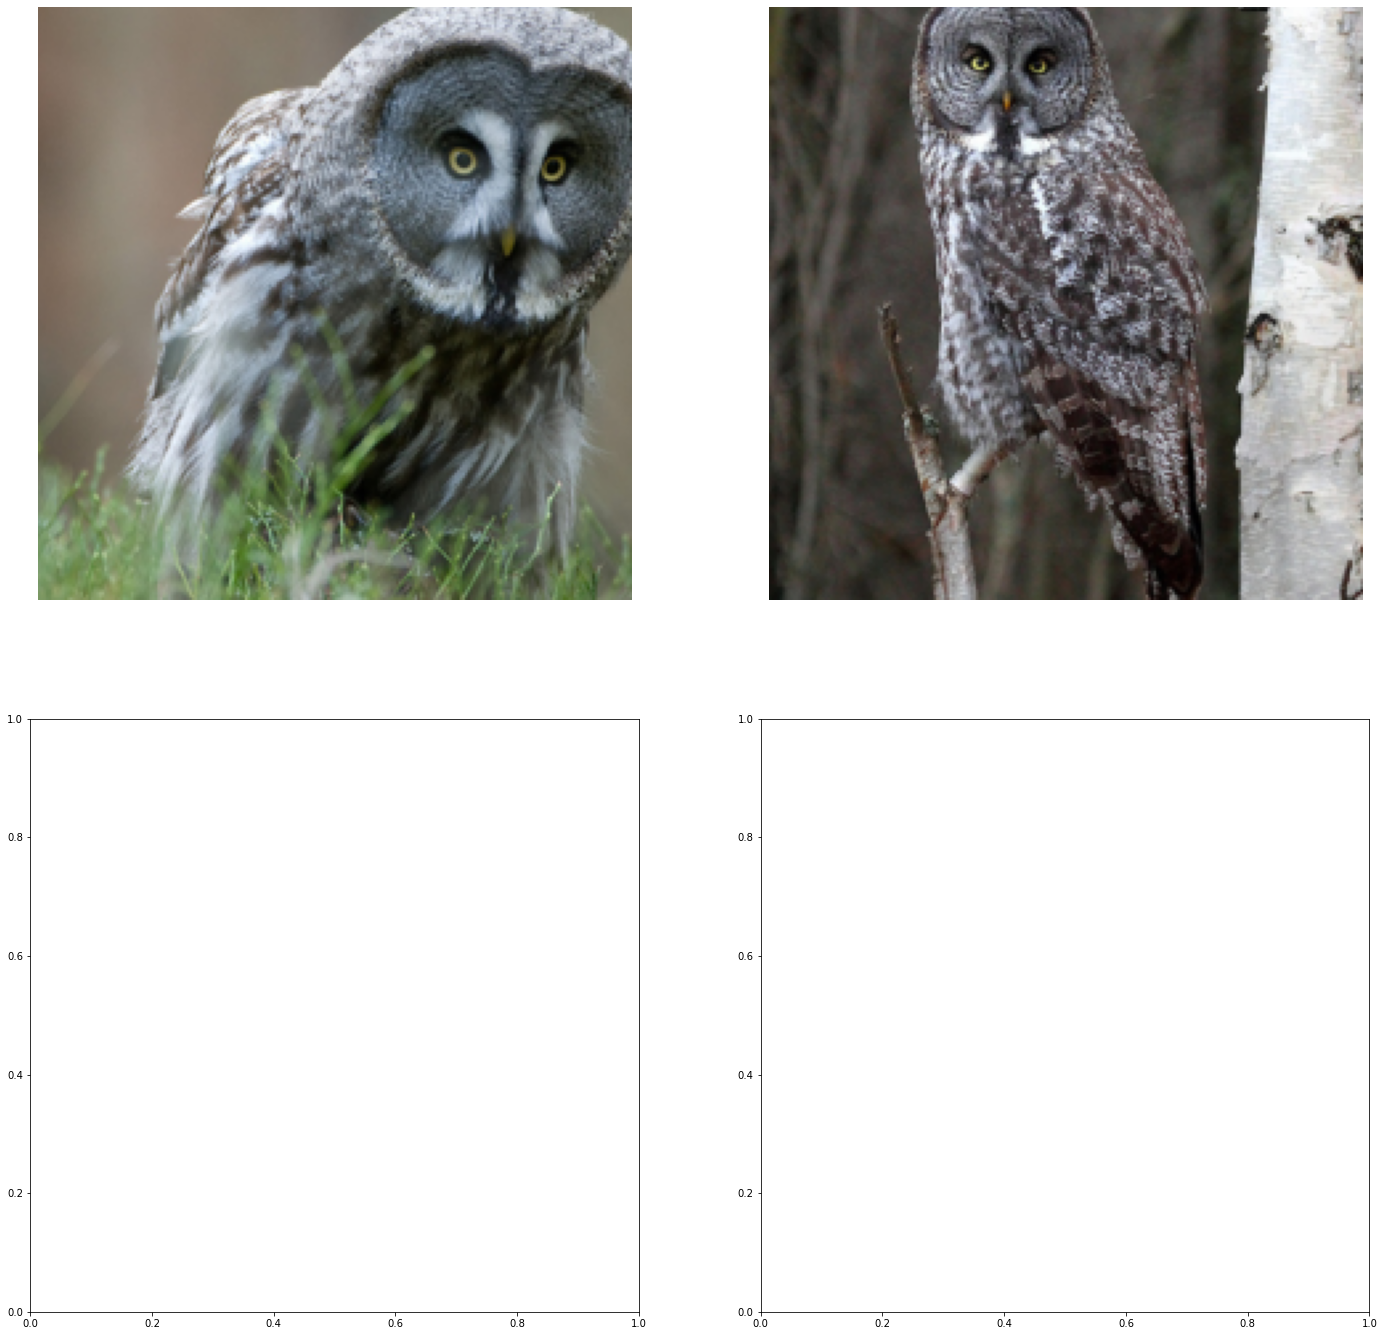

In [6]:
user.plot(true_user_data)

In [7]:
from breaching.cases.malicious_modifications.classattack_utils import print_gradients_norm, cal_single_gradients
single_gradients, single_losses = cal_single_gradients(user.model, loss_fn, true_user_data, setup=setup)
print_gradients_norm(single_gradients, single_losses)

grad norm   |   loss
0.0000 | 0.00
112368.8594 | 5.98


### Now reconstruct  a single "fished" user data point:

Now we launch the attack, reconstructing user data based on only the `server_payload` and the `shared_data`. 

You can interrupt the computation early to see a partial solution.

In [8]:
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], 
                                                      server.secrets, dryrun=cfg.dryrun)

| It: 1 | Rec. loss: 1.2636 |  Task loss: 10.3766 | T: 0.10s
| It: 1001 | Rec. loss: 0.2778 |  Task loss: 5.5408 | T: 47.42s
| It: 2001 | Rec. loss: 0.2787 |  Task loss: 6.1798 | T: 36.88s
| It: 3001 | Rec. loss: 0.2515 |  Task loss: 6.3325 | T: 36.83s
| It: 4001 | Rec. loss: 0.2307 |  Task loss: 6.3434 | T: 36.94s
| It: 5001 | Rec. loss: 0.2365 |  Task loss: 6.9194 | T: 36.87s
| It: 6001 | Rec. loss: 0.2356 |  Task loss: 6.9812 | T: 36.94s
| It: 7001 | Rec. loss: 0.2265 |  Task loss: 6.9573 | T: 37.61s
| It: 8001 | Rec. loss: 0.2322 |  Task loss: 6.8334 | T: 37.55s
| It: 9001 | Rec. loss: 0.2251 |  Task loss: 7.1023 | T: 36.84s
| It: 10001 | Rec. loss: 0.2107 |  Task loss: 6.8951 | T: 36.81s
| It: 11001 | Rec. loss: 0.2059 |  Task loss: 6.9060 | T: 37.86s
| It: 12001 | Rec. loss: 0.2085 |  Task loss: 7.1567 | T: 37.30s
| It: 13001 | Rec. loss: 0.1950 |  Task loss: 6.8633 | T: 36.92s
| It: 14001 | Rec. loss: 0.1884 |  Task loss: 6.7466 | T: 36.89s
| It: 15001 | Rec. loss: 0.1999 |  Tas

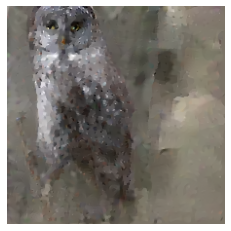

In [9]:
fished_data = dict(data=reconstructed_user_data["data"][server.secrets["ClassAttack"]["target_indx"]][None], 
                   labels=None)
user.plot(fished_data)

Next we'll evaluate metrics, comparing the `reconstructed_user_data` to the `true_user_data`.

In [10]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

METRICS: | MSE: 0.0469 | PSNR: 13.46 | FMSE: 1.3332e+01 | LPIPS: 0.76|
 R-PSNR: 14.12 | IIP-pixel: 0.00% | SSIM: 0.1600 | max R-PSNR: 14.71 | max SSIM: 0.3162 | Label Acc: 100.00%


And finally, we also plot the reconstructed data:

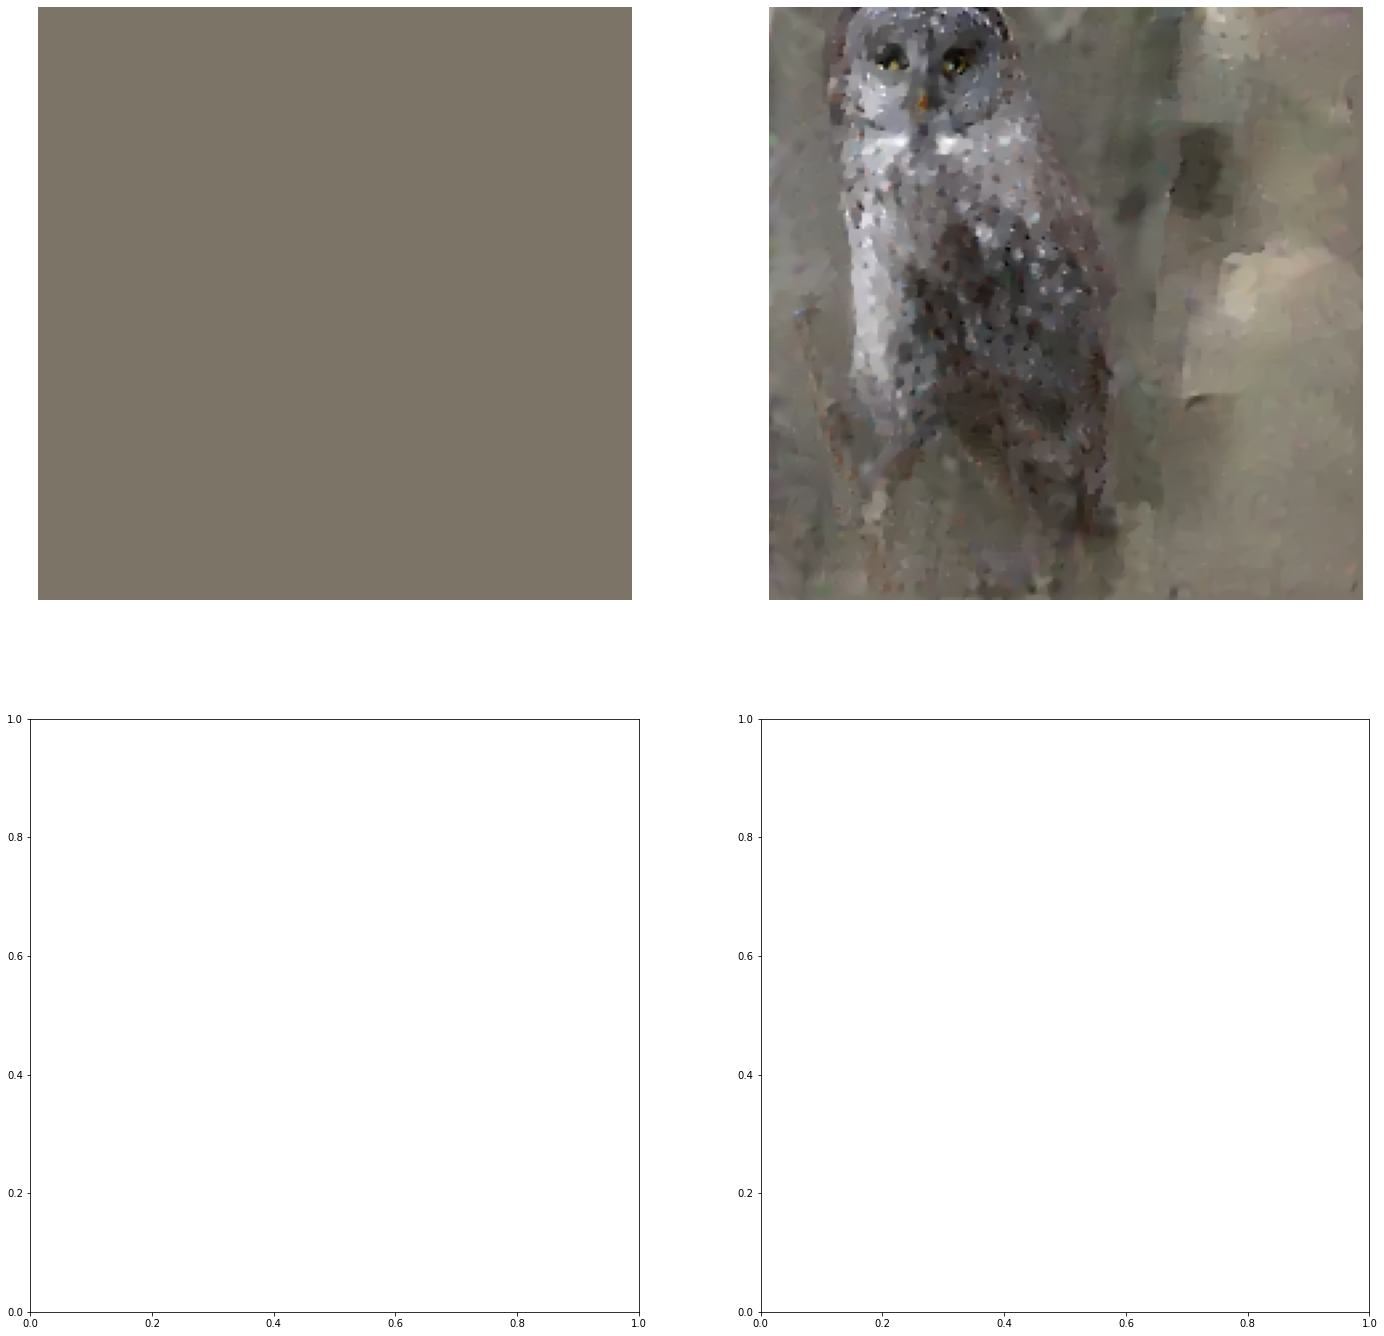

In [11]:
user.plot(reconstructed_user_data)

### Notes:
* You can use `cal_single_gradients` and `print_gradients_norm` from `malicious_modifications.classattack_utils` to verify that only one of the user data points has a non-neglible gradient norm